In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

# Stay classification: cluster-splitting with box-refinement & shifting boxes

## Algorithm

1. `get_clusters_3`
    1. initial clustering and merging
        1. initial pass
            1. confine the errors and speeds up the compute.
        2. identifies clusters based on spatio-temporal nearness
            1. events must first be close in time $\to$ identifies many small clusters
            2. adding a new event must be close to the statistical center of a cluster
        3. adjacent clusters are merged when they not sufficiently separated         
2. `get_extended_clusters`
    1. extend the cluster "boxes" bwd/fwd to obtain limits
3. `separate_clusters_hier`
    1. identify and separate overlapping clusters
4. `merge_combo`
    1. since the above splits clusters, need to re-merge
5. `shift_box`
    1. in order to identify small clusters as part of travels, shift the box fwd/bwd and look for changes
        * **TODO** apply _only_ to small enough clusters
6. `get_iqr_trimmed_clusters`
    1. refine the cluster limits by keeping only events which fall within the IQR of the cluster.

## Current evaluation

### Results 

Mostly, the results are good: more than 80% of the trajectories have prec and/or recall above 0.8

The main issue
* loss of precision due to non-stays being identified
    * this (loss) is increased with higher event density but compensated by an increase in recall
        * since many clusters are identified and the stay events have a higher probability of being classified as stay events.
<br/>

**TODO** since stay events are classified and not the accuracy of the stays, it would be useful to have a measure of the stay accuracy: _ie_ once a stay is identified, how much of that stay is correctly classified.

* 40% of chains result in some problem:
    * not correct stays; p/rec are below 0.8
    * leading 25% with 4 stays, 15% with 2 or fewer stays
    * **Note** these have not all been checked to see where the main problems are
        * missing large stays
        
* the rest has not been evaluated

### Pros
* can separate sequence and identify rudimentary clusters

### Cons
* can't distinguish all stays from travels 
    * nothing created to do so.

## ToDos

* Collect and put everything into scripts and have a clean new module with the current work.
* check that the newly split clusters are 
    * contain enough samples
    * $\checkmark$ ~~have a total duration longer than the threshold~~ see `get_extended_clusters`
    * $\checkmark$ ~~are not embedded within another cluster~~ possible, but unused; see `separate_embedded_clusters`
* $\checkmark$ ~~check that there are no embedded clusters~~ see `separate_embedded_clusters`
    * ~~times don't overlap~~ $\checkmark\to$ have function
    * ~~if refined clusters are embedded, check if one cluster is noise~~ ignored
* check the stddev of the refined clusters are smaller
* check on adjacent clusters
    * $\checkmark$ ~~check on the limits of time between adjacent clusters, esp. when they have the same mean and/or median~~ see `merge_clusters_combo`
        * if at $x_a$ for $t_1$ then again at $x_a$ for $t_2$, duration between going from and back to $x_a$ should reflect some mimimal amount of time ($2\times$ travel and a stay), 
            * e.g. 
                * from $x_a$ to an unknown $x_b$ with a stay at $x_b$ of the miminum duration and then back to $x_a$ 
                * should satisfy some criterion or _there is no inbetween travel and $t_1$ and $t_2$ are part of the same cluster_
    * $\checkmark$ ~~check of the metrics for inter-subcluster gaps~~ see `merge_clusters_combo`
        * these are also clusters but unlabeled after the first round of clustering
    * **!!!** check that the identified stays during the substages are not immediately adjacent
        * _ie_ no stays should have indices like `[10, ..., 20]` followed by `[21, ..., 30]`
            * such stays are possible $\to$ but there should be a minimum travel time if the locations are distinct
* check the gaps between (short) clusters
    * look for limits for the length of a travel
* improve the evaluations to 
    * consider travels' p/recs
    * the correct number of stays
        * then check the p/rec of those stays

In [4]:
import numpy as np
import pandas as pd

In [5]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [6]:
# #############################################################################
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 10)]

from random import shuffle

In [8]:
shuffle(colors)

In [9]:
from helper__3stays_v3_scripts import switch_indices

In [10]:
from synthetic_data.plotting import plot_trajectory, add_plot_trajectory, add_plot_seg_boxes

In [11]:
from helper__3stays_v3_scripts__plotting import plot_cluster_boxplots, add_plot_cluster_boxplots

In [12]:
print_clusts = lambda cluster_list : [print(f"[{c[0]:4d},{c[-1]:4d}]") for c in cluster_list]
#print_ctimes = lambda cluster_list : [print(f"[{time_arr[c[0]]:6.3f},{time_arr[c[-1]]:6.3f}]") for c in cluster_list]
#print_ctdiff = lambda cluster_list : [print(f"{time_arr[c[-1]] - time_arr[c[0]]:6.3f}") for c in cluster_list]
#print_times = lambda l: list(map(lambda x: f"{x:6.3f}",l))

In [22]:
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays

# Start here

In [ ]:

#from synthetic_data.trajectory_class import get_rand_traj
from synthetic_data.plotting import plot_trajectory, add_plot_seg_boxes

from synthetic_data.trajectory_class import get_trajectory
#from synthetic_data.trajectory import get_stay

dsec = 1/3600.0
t_total = np.arange(0,24,dsec)

In [13]:
from helper__get_clusters import get_clusters_3

In [18]:
from helper__3stays_v3_scripts import get_extended_clusters, separate_clusters
from helper__gaps import merge_clusters_combo
from helper__metric_box__explore import eval_synth_data

In [25]:
time_thresh = 1/6
dist_thresh=0.25

In [19]:
def split_list( l1, l2): 
    
    """
    Usage:
    split_list(range(10), list(range(4,7)))
    ([0, 1, 2, 3], [4, 5, 6], [7, 8, 9])
    """
    
    if len(l1) < len(l2):
        return ([e for e in l2 if e < min(l1)], l1, [e for e in l2 if e > max(l1)])
    else:
        return ([e for e in l1 if e < min(l2)], l2, [e for e in l1 if e > max(l2)])        

def list_intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 


def contains(a1,a2,b1,b2):
    """
    Check whether one range contains another
    """    
    return ((a1 >= b1) & (a2 <= b2))

inter_bounds = lambda p1, p2: intersecting_bounds(p1[0],p1[-1],p2[0],p2[-1])
conta_bounds = lambda p1, p2: contains(p1[0],p1[-1],p2[0],p2[-1])

def intersecting_bounds(a1,a2,b1,b2):
    """
    Check whether two ranges intersect
    
    Specifically: b1 < a1 < b2 and a2 > b2
    """

    cond1 = ((a1 >= b1) & (a1 <= b2)) | \
            ((b1 >= a1) & (b1 <= a2))    
    
    return cond1

'''
def intersecting_bounds(a1,a2,b1,b2):
    """
    Check whether two ranges intersect
    
    Specifically: b1 < a1 < b2 and a2 > b2
    """
    print(a1,a2,b1,b2)
    
    print((a1 >  b1), (a1 <= b2), (a2 >= b2))
    print((a1 >= b1), (a1 <  b2), (a2 >  b2))
    
    cond1 = (((a1 >  b1) & (a1 < b2)) & (a2 > b2)) | \
             (((a1 > b1) & (a1 < b2)) & (a2 > b2))
    return cond1
'''

def get_sorted_keys(clusts):
    d = {}
    for n, c in enumerate(clusts):
        d[n] = len(c)

    return [k for k, v in sorted(d.items(), key=lambda item: item[1])]

def check_intersecting_clusters_inds(clusters):
    m = 0
    while (m < len(clusters)):
        # Biggest cluster
        c1 = clusters[m]
        n = m+1
        while (n < len(clusters)):

            if n == m:
                n+=1
                continue

            c2 = clusters[n]
            if inter_bounds(c1,c2):
                return True, m,n
            else:
                n+=1
        m+=1
    return False, 999, 999

def check_intersecting_clusters(clusters):
    
    result, _ , _ = check_intersecting_clusters_inds(clusters)
 
    return result

def separate_clusters_hier(clusters, verbose=False):
    """
    
    Test:
    clusts = [list(range(2,4)), list(range(8)), list(range(4,8)), list(range(6,10))]
    separate_clusters_hier(clusts)
    [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]
    """    
    # Check if any clusters intersect
    new_clusts = clusters.copy()
    
    result, m, n = check_intersecting_clusters_inds(new_clusts)
    
    if verbose: print(result)    
    
    if result:
        if verbose: print(m, n)
    else:
        return clusters

    while result:
        
        if verbose: print_clusts(new_clusts)
        if verbose: print(len(new_clusts))
        c1 = new_clusts.pop(m)
        if m < n: 
            n-=1
        c2 = new_clusts.pop(n)

        if verbose: print(len(new_clusts))
        if verbose: print(f"{m:4d}: [{c1[0]:4d},{c1[-1]:4d}] and [{c2[0]:4d},{c2[-1]:4d}]")

        '''sc1 = set(c1)
        sc2 = set(c2)

        intersexion = sc1.intersection(sc2)

        sc1_diff = sc1.difference(intersexion)
        sc2_diff = sc2.difference(intersexion)                
        '''
        
        sc1_diff, intersec, sc2_diff = split_list(c1,c2)        
        
        #sc1_diff = list(sc1_diff)
        if len(sc1_diff) > 0:
            new_clusts.append(sc1_diff)
        if verbose: print("len(sc1_diff)",len(sc1_diff))
        
        #intersexion = list(intersexion)
        if len(intersec) > 0:
            new_clusts.append(intersec)
        if verbose: print("len(intersexion)",len(intersec))
        
        #sc2_diff = list(sc2_diff)
        if len(sc2_diff) > 0:
            new_clusts.append(sc2_diff)
        if verbose: print("len(sc2_diff)",len(sc2_diff))
        
        if verbose: print(len(new_clusts))
        if verbose: print_clusts(new_clusts) 
        
        result, m, n = check_intersecting_clusters_inds(new_clusts)
        if verbose: print(result,m,n)
        if verbose: print()
        
    return new_clusts

In [39]:
from helper__metric_box__explore import get_iqr_mask

def get_iqr_trimmed_clusters(x_arr, clusters, iqr_factor=1.5, within=True, verbose=False):
    new_clusters = []
    for c in clusters:
        cc = get_iqr_mask(x_arr[c], c, iqr_factor, within)[0]
        
        ccc = list(range(cc[0], cc[-1]+1))
        
        if verbose: print(f"[{c[0]:4d},{c[-1]:4d}] vs. [{cc[0]:4d},{cc[-1]:4d}]")
        #f" vs. [{ccc[0]:4d},{ccc[-1]:4d}]" )

        new_clusters.append(ccc)
        
    return new_clusters

In [ ]:
def contiguous_sublists(lst1, lst2): 
    """
    Split intersecting and interleaved lists 
    into maximal contiguous sublists
    """
    #print(lst1, lst2)
    # Gather all unique elements together and order
    lst3 = sorted(list(set(lst1+lst2)))

    # Classifying function according to origin and intersections
    def get_flag(e):
        if (e in lst1) & (e in lst2):
            return 0
        elif (e in lst1):
            return 1
        else:
            return 2
    
    # output list
    all_lists = []
    
    # Initializations
    e = lst3[0]    
    flag = get_flag(e)
    lst = [e]
    
    # Walk through all elements
    for e in lst3[1:]:
        flag_ = get_flag(e)
        
        if flag == flag_:
            lst.append(e)
        else:
            all_lists.append(lst)
            lst = [e]
            flag = flag_
    
    # close the last list
    all_lists.append(lst)        
    
    # Sort the lists (maybe unnecessary)
    #all_lists = sorted([l for l in all_lists if l != []])
    
    return all_lists    

In [ ]:
def separate_embedded_clusters(clusters, verbose=False):
    """
    
    Test:
    clusts = [list(range(5)), list(range(2,4)), list(range(8)), list(range(4,8)), list(range(6,10))]
    separate_embedded_clusters(clusts)
    [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]
    """    
    # Check if any clusters intersect
    new_clusts = clusters.copy()
    
    result, m, n = check_intersecting_clusters_inds(new_clusts)
    
    if verbose: print(result)    
    
    if result:
        if verbose: print(m, n)
    else:
        return clusters

    while result:
        
        #if verbose: print_clusts(new_clusts)
        if verbose: print(len(new_clusts))
        c1 = new_clusts.pop(m)
        if m < n: 
            n-=1
        c2 = new_clusts.pop(n)

        if verbose: print(len(new_clusts))
        if verbose: print(f"{m:4d}: [{c1[0]:4d},{c1[-1]:4d}] and [{c2[0]:4d},{c2[-1]:4d}]")

        '''sc1 = set(c1)
        sc2 = set(c2)

        intersexion = sc1.intersection(sc2)

        sc1_diff = sc1.difference(intersexion)
        sc2_diff = sc2.difference(intersexion)                
        '''
        
        new_clusts.extend(contiguous_sublists(c1, c2))
        '''        
        sc1_diff, intersec, sc2_diff = split_list(c1,c2)        
        
        #sc1_diff = list(sc1_diff)
        if len(sc1_diff) > 0:
            new_clusts.append(sc1_diff)
        if verbose: print("len(sc1_diff)",len(sc1_diff))
        
        #intersexion = list(intersexion)
        if len(intersec) > 0:
            new_clusts.append(intersec)
        if verbose: print("len(intersexion)",len(intersec))
        
        #sc2_diff = list(sc2_diff)
        if len(sc2_diff) > 0:
            new_clusts.append(sc2_diff)
        if verbose: print("len(sc2_diff)",len(sc2_diff))
        '''
        if verbose: print(len(new_clusts))
        #if verbose: print_clusts(new_clusts) 
        
        result, m, n = check_intersecting_clusters_inds(new_clusts)
        if verbose: print(result,m,n)
        if verbose: print()

    return sorted(new_clusts)            

In [ ]:
from helper__3stays_v3_scripts__eval import eval_synth_data_clusters

print(eval_synth_data(segments, t_arr, clusters_6))

print(eval_synth_data_clusters(segments, t_arr, clusters_6))

print(eval_synth_data_clusters(segments, t_arr, clusters_6, True))

In [57]:
from stay_classification.box_classifier.box_method import get_time_ind
from helper__3stays_v3_scripts import get_iqr_mask, get_iqr_mask_x, _get_iqr


def shift_box(t_arr, x_arr, clusters, time_thresh, dist_thresh, verbose=False):
    """
    
    """
    t_thresh_fact = 1.0
    
    within=True
    
    iqr_fact = 0 #1.5
    
    new_clusters = []
    
    for c in clusters:
    
        #print(c[-1]-c[0], len(c)-1)
        offset = c[0]
        
        q25, q75 = _get_iqr(x_arr[c])

        iqr = abs(q75 - q25)
            
        # Bwd-shifted bounds
        lower_ind = get_time_ind(t_arr, t_arr[c[ 0]], t_thresh_fact*time_thresh, -1)
        upper_ind = get_time_ind(t_arr, t_arr[c[-1]], t_thresh_fact*time_thresh, -1)
    
        sub_arr = x_arr[lower_ind:upper_ind+1].copy()

        if within:
            mask = np.where((sub_arr >= (q25 - iqr_fact * iqr)) & (sub_arr <= (q75 + iqr_fact * iqr)))[0]

        else:
            mask =  np.where((sub_arr < (q25 - iqr_fact * iqr)) | (sub_arr > (q75 + iqr_fact * iqr)))[0]

        bwd_mask = mask + lower_ind
        
        strg = f"[{c[0]:6d}, {c[-1]:6d}]: {np.mean(x_arr[c]):6.3f}\t"
        
        if bwd_mask.size > 0:
            #print(len(sub_arr),  "\t[", mask[0], mask[-1], "]\t[", bwd_mask[0], bwd_mask[-1],  "]\t[", c[0], c[-1], "]", bwd_mask[-10:])            
            bwd_mean = np.mean(x_arr[bwd_mask])
        else:
            bwd_mean = np.nan
            
        strg += f"BWD: [{lower_ind:6d}, {upper_ind:6d}]: {len(bwd_mask):5d}: {bwd_mean:6.3f}\t"
        
        # Fwd-shifted bounds
        lower_ind = get_time_ind(t_arr, t_arr[c[ 0]], t_thresh_fact*time_thresh, 1)
        upper_ind = get_time_ind(t_arr, t_arr[c[-1]], t_thresh_fact*time_thresh, 1)
    
        sub_arr = x_arr[lower_ind:upper_ind+1].copy()
        
        if within:
            mask = np.where((sub_arr >= (q25 - iqr_fact * iqr)) & (sub_arr <= (q75 + iqr_fact * iqr)))[0]

        else:
            mask =  np.where((sub_arr < (q25 - iqr_fact * iqr)) | (sub_arr > (q75 + iqr_fact * iqr)))[0]

        fwd_mask = mask + lower_ind
        
        if fwd_mask.size > 0:
            fwd_mean = np.mean(x_arr[fwd_mask])
        else:
            fwd_mean = np.nan
        
        strg += f"FWD: [{lower_ind:6d}, {upper_ind:6d}]: {len(fwd_mask):5d}: {fwd_mean:6.3f}\t\t{abs(bwd_mean - fwd_mean) < 0.5*dist_thresh}"
        if verbose: print(strg)
        
        if (len(bwd_mask) > 0 ) & (len(fwd_mask) > 0):
            if abs(bwd_mean - fwd_mean) < 0.5*dist_thresh:
                new_clusters.append(c)
            
    return new_clusters

In [ ]:
from helper__3stays_v3_scripts import _get_iqr
def get_iqr_mask_xx(sub_arr, offset, iqr_bounds, iqr_fact = 1.5, within=True, verbose=False):
    """
    """
    
    #TODO: rename `x_arr` --> `sub_arr`, `cluster` --> `offset` 
    
    # Mask to include only events within the IQR
    if iqr_bounds != None:
        #if verbose: print("Getting input bounds", iqr_bounds)
        q25, q75 = iqr_bounds
    else:
        q25, q75 = _get_iqr(sub_arr)
    
    iqr = abs(q75 - q25)
        
    print(q25,q75)
    print(q25 - iqr_fact * iqr, q75 + iqr_fact * iqr)
    if within:
        mask = np.where((sub_arr >= (q25 - iqr_fact * iqr)) & (sub_arr <= (q75 + iqr_fact * iqr)))
        
    else:
        mask =  np.where((sub_arr < (q25 - iqr_fact * iqr)) | (sub_arr > (q75 + iqr_fact * iqr)))
    
    mask[0][:] += offset
    
    return mask

In [ ]:
from helper__metric_box__explore import iqr_metrics, get_boxplot_quants, get_clusters_rev 

def plot_cluster_boxplots_xlim(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters, clusters_rev, configs, xlim=[5.75,18.25]):
    """
    """
    dist_thresh = configs['dist_thresh']
    
    ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, dist_thresh);
    add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

    ax.set_xlim(xlim)

    bp_data, labels, positions, widths = get_boxplot_quants(time_arr, noise_arr, clusters)

    axt = ax.twiny()
    _ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='red'), widths=widths)   

    for label in axt.get_xticklabels():
        label.set_rotation(90)
    axt.set_xticklabels(labels, visible=True, color='red')


    axt.set_xlim(ax.get_xlim())
    axt.legend(['forward clusters'], bbox_to_anchor=(1.15, 0.6), loc='center right', ncol=1);


    bp_data, labels, positions, widths = get_boxplot_quants(time_arr[::-1], noise_arr[::-1], clusters_rev)

    axt = ax.twiny()
    labels = list(map(lambda x: f"{x:.2f}", positions))
    _ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='blue'), widths=widths)
    axt.legend(['reverse clusters'], bbox_to_anchor=(1.15, 0.4), loc='center right', ncol=1);

    for label in axt.get_xticklabels():
        label.set_rotation(90)
        
    axt.set_xticklabels(labels, visible=False)

    axt.set_xlim(ax.get_xlim())
    ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1)
    
    return ax

## Gap metrics

In [43]:
from helper__gaps import get_intercluster_metrics, get_gap_dist, get_gap_time

def get_gap_metrics(c1, c2, t_arr, x_arr, time_thresh, min_speed=3.6):
    """
    Calculate some metrics for a gap: 
        * the duration of the gap, 
        * the minimal possible duration of the gap to include a stay
        * a location statistic of the gap
    """
    
    # Get the gap indices between adjacent clusters
    gap = list(range(c1[-1],c2[0]+1))
    gap_len = len(gap)
    interstay_dist_medi = abs(np.median(x_arr[c1])-np.median(x_arr[c2]))
    interstay_dist_mean = abs(np.mean(x_arr[c1])-np.mean(x_arr[c2]))
    
    # Returns
    ## Calulate the duration between adjacent clusters
    gap_time = get_gap_time(t_arr,c1,c2)

    ## Calculate the minimal time between two clusters to include two travels and a stay
    dur1 = get_gap_dist(x_arr,c1, gap)/min_speed
    dur2 = get_gap_dist(x_arr,c2, gap)/min_speed
    
    ## Calculate a statistic (ie the median) of the events contained in a gap
    gap_mean   = np.mean(x_arr[gap])
    gap_median = np.median(x_arr[gap])
    '''
    print(f"{gap_len:4d}, {gap_time:6.3f}, {interstay_dist_medi:6.3f}, {interstay_dist_mean:6.3f}, {gap_mean:6.3f}, {gap_median:6.3f}")
    '''
    warning = ""
    if gap_time < time_thresh: 
        warning = "WARNING: too short"
    
    return f"{gap_len:4d}, {gap_time:6.3f}, {interstay_dist_medi:6.3f}, {interstay_dist_mean:6.3f}, {gap_mean:6.3f}, {gap_median:6.3f}  {warning}"

def get_clust_metrics(gap, t_arr, x_arr, time_thresh, min_speed=3.6):
    """
    Calculate some metrics for a gap: 
        * the duration of the gap, 
        * the minimal possible duration of the gap to include a stay
        * a location statistic of the gap
    """
    
    # Get the gap indices between adjacent clusters
    gap_len = len(gap)

    
    # Returns
    ## Calulate the duration between adjacent clusters
    gap_time = t_arr[gap[-1]]-t_arr[gap[0]]

    ## Calculate the minimal time between two clusters to include two travels and a stay
    #dur1 = get_gap_dist(x_arr,c1, gap)/min_speed
    #dur2 = get_gap_dist(x_arr,c2, gap)/min_speed
    
    ## Calculate a statistic (ie the median) of the events contained in a gap
    gap_mean   = np.mean(x_arr[gap])
    gap_median = np.median(x_arr[gap])
    
    return f"{gap_len:4d}, {gap_time:6.3f},   ----,   ----, {gap_mean:6.3f}, {gap_median:6.3f}"

def get_gap_dist(x_arr,c1,c2):
    """
    Gets the spatial difference between two medians of neighboring clusters
    """
    #return get_gap_dist_generic(x_arr[c1], np.median(x_arr[c2]))
    return abs(np.median(x_arr[c1])-np.median(x_arr[c2]))
 

```
rand_range = lambda min_, max_, size: (max_-min_)*np.random.random_sample(size=size) + min_

event_frac = rand_range(0.01,0.001, 1)[0]
duplicate_frac = 0.30 #rand_range(1,0.3,0.05)[0]

print(f"Event frac. = {event_frac:6.3f}\nDupli. frac. = {duplicate_frac:6.3f}")

configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}
```

In [14]:
from datetime import datetime

import os

date_tag = datetime.today().strftime('%Y%m%d')

data_dir = f"./testdata_training_set__canonical_3stays/"

try:
    os.makedirs(data_dir)
except OSError as e:
    print(e)

[Errno 17] File exists: './testdata_training_set__canonical_3stays/'


In [15]:
import pickle

In [31]:
min_configs = {
    'time_thresh':time_thresh,
    'dist_thresh':dist_thresh
}

In [87]:
lens = []
precs = []
recs = []

precrec_limit = 0.85

ii = 0

length_criterion_break = False
iqr_trim = False
verbose = False


total = 100


for ii in range(0, 100):

    stays_tag = 3
    trajectory_tag = f"trajectory_{stays_tag}stays__{ii}"    
    path_to_file =  data_dir + trajectory_tag
    
    trajectory = pickle.load( open(path_to_file + ".pkl", "rb") )    
    
    segments = trajectory['segments']
    time_arr = trajectory['time_arr']
    raw_arr = trajectory['raw_locs_arr']
    noise_arr = trajectory['nse_locs_arr']
    t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))


    all_clusters = []
    stage_titels = []

    try:

        stage_titel = f"Stage {1}: get mini-clusters and merging"
        if verbose: print(stage_titel)
        clusters_1 = get_clusters_3(time_arr, noise_arr, dist_thresh, time_thresh)
        if verbose: print(len(clusters_1), "Clusters:")
        if verbose: print_clusts(clusters_1);
        if verbose: print()
        all_clusters.append(clusters_1)
        stage_titels.append(stage_titel)


        stage_titel = f"Stage {2}: extend clusters and IQR-filter"
        if verbose: print(stage_titel)
        clusters_1 = sorted([sorted(c) for c in clusters_1])                        
        clusters_2 = get_extended_clusters(time_arr, noise_arr, clusters_1, time_thresh)
        if verbose: print(len(clusters_2), "Clusters:")
        if verbose: print_clusts(clusters_2);
        if verbose: print()
        all_clusters.append(clusters_2)
        stage_titels.append(stage_titel)


        stage_titel = f"Stage {3}: separate overlapping clusters"
        if verbose: print(stage_titel)
        clusters_2 = sorted([sorted(c) for c in clusters_2])    
        #clusters_3 = separate_embedded_clusters(clusters_2)
        clusters_3 = separate_clusters_hier(clusters_2)
        if verbose: print(len(clusters_3), "Clusters:")
        if verbose: print_clusts(clusters_3);
        if verbose: print()    
        all_clusters.append(clusters_3)
        stage_titels.append(stage_titel)


        stage_titel = f"Stage {4}: merge nearby clusters"
        if verbose: print(stage_titel)
        clusters_3 = sorted([sorted(c) for c in clusters_3])
        clusters_4 = merge_clusters_combo(time_arr, noise_arr, clusters_3, dist_thresh, time_thresh)
        if verbose: print(len(clusters_4), "Clusters:")
        if verbose: print_clusts(clusters_4);    
        if verbose: print()
        all_clusters.append(clusters_4)
        stage_titels.append(stage_titel)


        stage_titel = f"Stage {5}: shift the boxes"
        if verbose: print(stage_titel)
        clusters_4 = sorted([sorted(c) for c in clusters_4])
        clusters_5 = shift_box(time_arr, noise_arr, clusters_4, time_thresh, dist_thresh);
        if verbose: print(len(clusters_5), "Clusters:")
        if verbose: print_clusts(clusters_5);
        if verbose: print()
        all_clusters.append(clusters_5)
        stage_titels.append(stage_titel)


        stage_titel = f"Stage {6}: filter regions by IQR"
        if verbose: print(stage_titel)
        clusters_5 = sorted([sorted(c) for c in clusters_5])
        #clusters_5 = [list(range(c[0],c[-1]+1)) for c in clusters_5]
        #iqr_trim = True
        if iqr_trim:        
            clusters_6 = get_iqr_trimmed_clusters(noise_arr, clusters_5, 1.5);
            if verbose: print(len(clusters_6), "Clusters:")
            if verbose: print_clusts(clusters_6);
        else: 
            if verbose: print("No IQR-trim")
            clusters_6 = clusters_5.copy()
        if verbose: print()
        all_clusters.append(clusters_6)
        stage_titels.append(stage_titel)

        continuation = False
    except:                    
        print("Failed at",ii)
        #print(stays)
        continue

    final_len=len(all_clusters[-1])
    prec, rec, conmat = eval_synth_data(segments, time_arr, all_clusters[-1])

    if (prec < precrec_limit) | (rec < precrec_limit) | (final_len != stays_tag):
        reason = ""
        if (final_len != stays_tag): 
            reason += "wrong stays"
        if (prec < precrec_limit):
            reason += "; p low"
        if (rec < precrec_limit):
            reason += "; r low"
        print(ii, reason)
        
        all_clusters = [
            clusters_1,
            clusters_2,
            clusters_3,
            clusters_4,
            clusters_5,
            clusters_6    
        ]

        len_all_clusts = len(all_clusters)

        fig, axs = plt.subplots(len_all_clusts,1,figsize=[20,len_all_clusts*6])

        ylim = [noise_arr.min()-2*dist_thresh, noise_arr.max()+2*dist_thresh]

        axs =axs.flatten()

        for i in range(len_all_clusts):
            try:
                ax = axs[i]
                add_plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, all_clusters[i], switch_indices(all_clusters[i], time_arr.shape[0]), min_configs, ax)
                ax.set_ylim(ylim);
                ax.set_title(f"Stage. {i}", fontsize=24)
            except:
                print("Plotting failed")
                pass

        fig.suptitle(f"{final_len:4d} Stays, prec. {prec:6.3f}, {rec:6.3f}", fontsize=16)
        
        staystr = f"{final_len}"
        precstr = f"{prec:6.3f}".strip().replace(".","o")
        recstr = f"{rec:6.3f}".strip().replace(".","o")

        stays_tag = int((x_segs.size)/3)
        notes = f"{staystr}stays_prec{precstr}_rec{recstr}"

        trajectory_tag = f"trajectory_{stays_tag}stays__{notes}"
        path_to_file =  data_dir + trajectory_tag

        plt.savefig(path_to_file + ".png")
        plt.close()
        #'''

    lens.append(len(clusters_5))
    precs.append(prec)
    recs.append(rec)

    if ii % 10 == 0:
        print(f"{ii:4d} of {total:5d}")


   0 of   100
3 wrong stays
8 wrong stays
  10 of   100
11 wrong stays
13 wrong stays
19 wrong stays
20 wrong stays
  20 of   100
23 wrong stays; p low; r low


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting failed
Plotting failed
24 wrong stays
  30 of   100
31 wrong stays; r low
33 wrong stays
34 wrong stays
35 wrong stays
36 wrong stays
  40 of   100
44 wrong stays
46 wrong stays
48 wrong stays; r low
50 wrong stays
  50 of   100
55 wrong stays; r low
57 wrong stays; r low
  60 of   100
61 wrong stays; r low
63 wrong stays
65 wrong stays; r low
69 wrong stays; p low; r low
  70 of   100
71 wrong stays
72 wrong stays
75 wrong stays
76 wrong stays
  80 of   100
81 wrong stays
84 wrong stays
86 wrong stays
88 wrong stays
89 wrong stays
  90 of   100
91 wrong stays
92 wrong stays
93 wrong stays
94 wrong stays


Text(0.5, 1.0, 'Stage. 5')

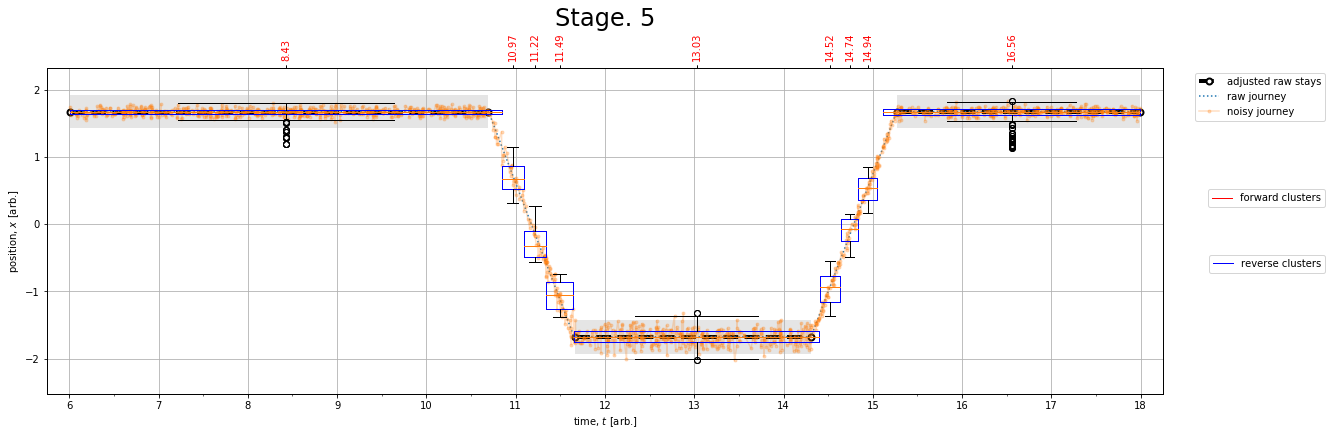

In [33]:
fig, ax = plt.subplots(1,1,figsize=[20,6])
add_plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, all_clusters[i], switch_indices(all_clusters[i], time_arr.shape[0]), min_configs, ax)
ax.set_ylim(ylim);
ax.set_title(f"Stage. {i}", fontsize=24)

## Revisit some bad files

In [60]:
trajectory_nr = 11

stays_tag = 3
trajectory_tag = f"trajectory_{stays_tag}stays__{trajectory_nr}"    
path_to_file =  data_dir + trajectory_tag

trajectory = pickle.load( open(data_dir + trajectory_tag + ".pkl", "rb") )

In [61]:
segments = trajectory['segments']
t_arr = trajectory['time_arr']
r_arr = trajectory['raw_locs_arr']
x_arr = trajectory['nse_locs_arr']

In [62]:
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, t_arr))

In [69]:
verbose = True

all_clusters = []
stage_titels = []

stage_titel = f"Stage {1}: get mini-clusters and merging"
if verbose: print(stage_titel)
clusters_1 = get_clusters_3(t_arr, x_arr, dist_thresh, time_thresh)
if verbose: print(len(clusters_1), "Clusters:")
if verbose: print_clusts(clusters_1);
if verbose: print()
all_clusters.append(clusters_1)
stage_titels.append(stage_titel)


stage_titel = f"Stage {2}: extend clusters and IQR-filter"
if verbose: print(stage_titel)
clusters_1 = sorted([sorted(c) for c in clusters_1])                        
clusters_2 = get_extended_clusters(t_arr, x_arr, clusters_1, time_thresh)
if verbose: print(len(clusters_2), "Clusters:")
if verbose: print_clusts(clusters_2);
if verbose: print()
all_clusters.append(clusters_2)
stage_titels.append(stage_titel)


stage_titel = f"Stage {3}: separate overlapping clusters"
if verbose: print(stage_titel)
clusters_2 = sorted([sorted(c) for c in clusters_2])    
#clusters_3 = separate_embedded_clusters(clusters_2)
clusters_3 = separate_clusters_hier(clusters_2)
if verbose: print(len(clusters_3), "Clusters:")
if verbose: print_clusts(clusters_3);
if verbose: print()    
all_clusters.append(clusters_3)
stage_titels.append(stage_titel)


stage_titel = f"Stage {4}: merge nearby clusters"
if verbose: print(stage_titel)
clusters_3 = sorted([sorted(c) for c in clusters_3])
clusters_4 = merge_clusters_combo(t_arr, x_arr, clusters_3, dist_thresh, time_thresh)
if verbose: print(len(clusters_4), "Clusters:")
if verbose: print_clusts(clusters_4);    
if verbose: print()
all_clusters.append(clusters_4)
stage_titels.append(stage_titel)


stage_titel = f"Stage {5}: shift the boxes"
if verbose: print(stage_titel)
clusters_4 = sorted([sorted(c) for c in clusters_4])
clusters_5 = shift_box(t_arr, x_arr, clusters_4, time_thresh, dist_thresh);
if verbose: print(len(clusters_5), "Clusters:")
if verbose: print_clusts(clusters_5);
if verbose: print()
all_clusters.append(clusters_5)
stage_titels.append(stage_titel)


stage_titel = f"Stage {6}: filter regions by IQR"
if verbose: print(stage_titel)
clusters_5 = sorted([sorted(c) for c in clusters_5])
#clusters_5 = [list(range(c[0],c[-1]+1)) for c in clusters_5]
#iqr_trim = True
if iqr_trim:        
    clusters_6 = get_iqr_trimmed_clusters(x_arr, clusters_5, 1.5);
    if verbose: print(len(clusters_6), "Clusters:")
    if verbose: print_clusts(clusters_6);
else: 
    if verbose: print("No IQR-trim")
    clusters_6 = clusters_5.copy()
if verbose: print()
all_clusters.append(clusters_6)
stage_titels.append(stage_titel)

Stage 1: get mini-clusters and merging
10 Clusters:
[   0, 307]
[ 308, 318]
[ 319, 330]
[ 331, 341]
[ 342, 705]
[ 706, 715]
[ 716, 732]
[ 733, 744]
[ 745, 760]
[ 763, 873]

Stage 2: extend clusters and IQR-filter
7 Clusters:
[   0, 307]
[ 342, 721]
[ 703, 724]
[ 706, 735]
[ 730, 750]
[ 739, 768]
[ 748, 873]

Stage 3: separate overlapping clusters
7 Clusters:
[   0, 307]
[ 342, 702]
[ 769, 873]
[ 703, 724]
[ 725, 729]
[ 730, 750]
[ 751, 768]

Stage 4: merge nearby clusters
6 Clusters:
[   0, 307]
[ 342, 702]
[ 703, 729]
[ 730, 750]
[ 751, 768]
[ 769, 873]

Stage 5: shift the boxes
4 Clusters:
[   0, 307]
[ 342, 702]
[ 730, 750]
[ 769, 873]

Stage 6: filter regions by IQR
4 Clusters:
[   0, 301]
[ 343, 702]
[ 730, 743]
[ 769, 873]



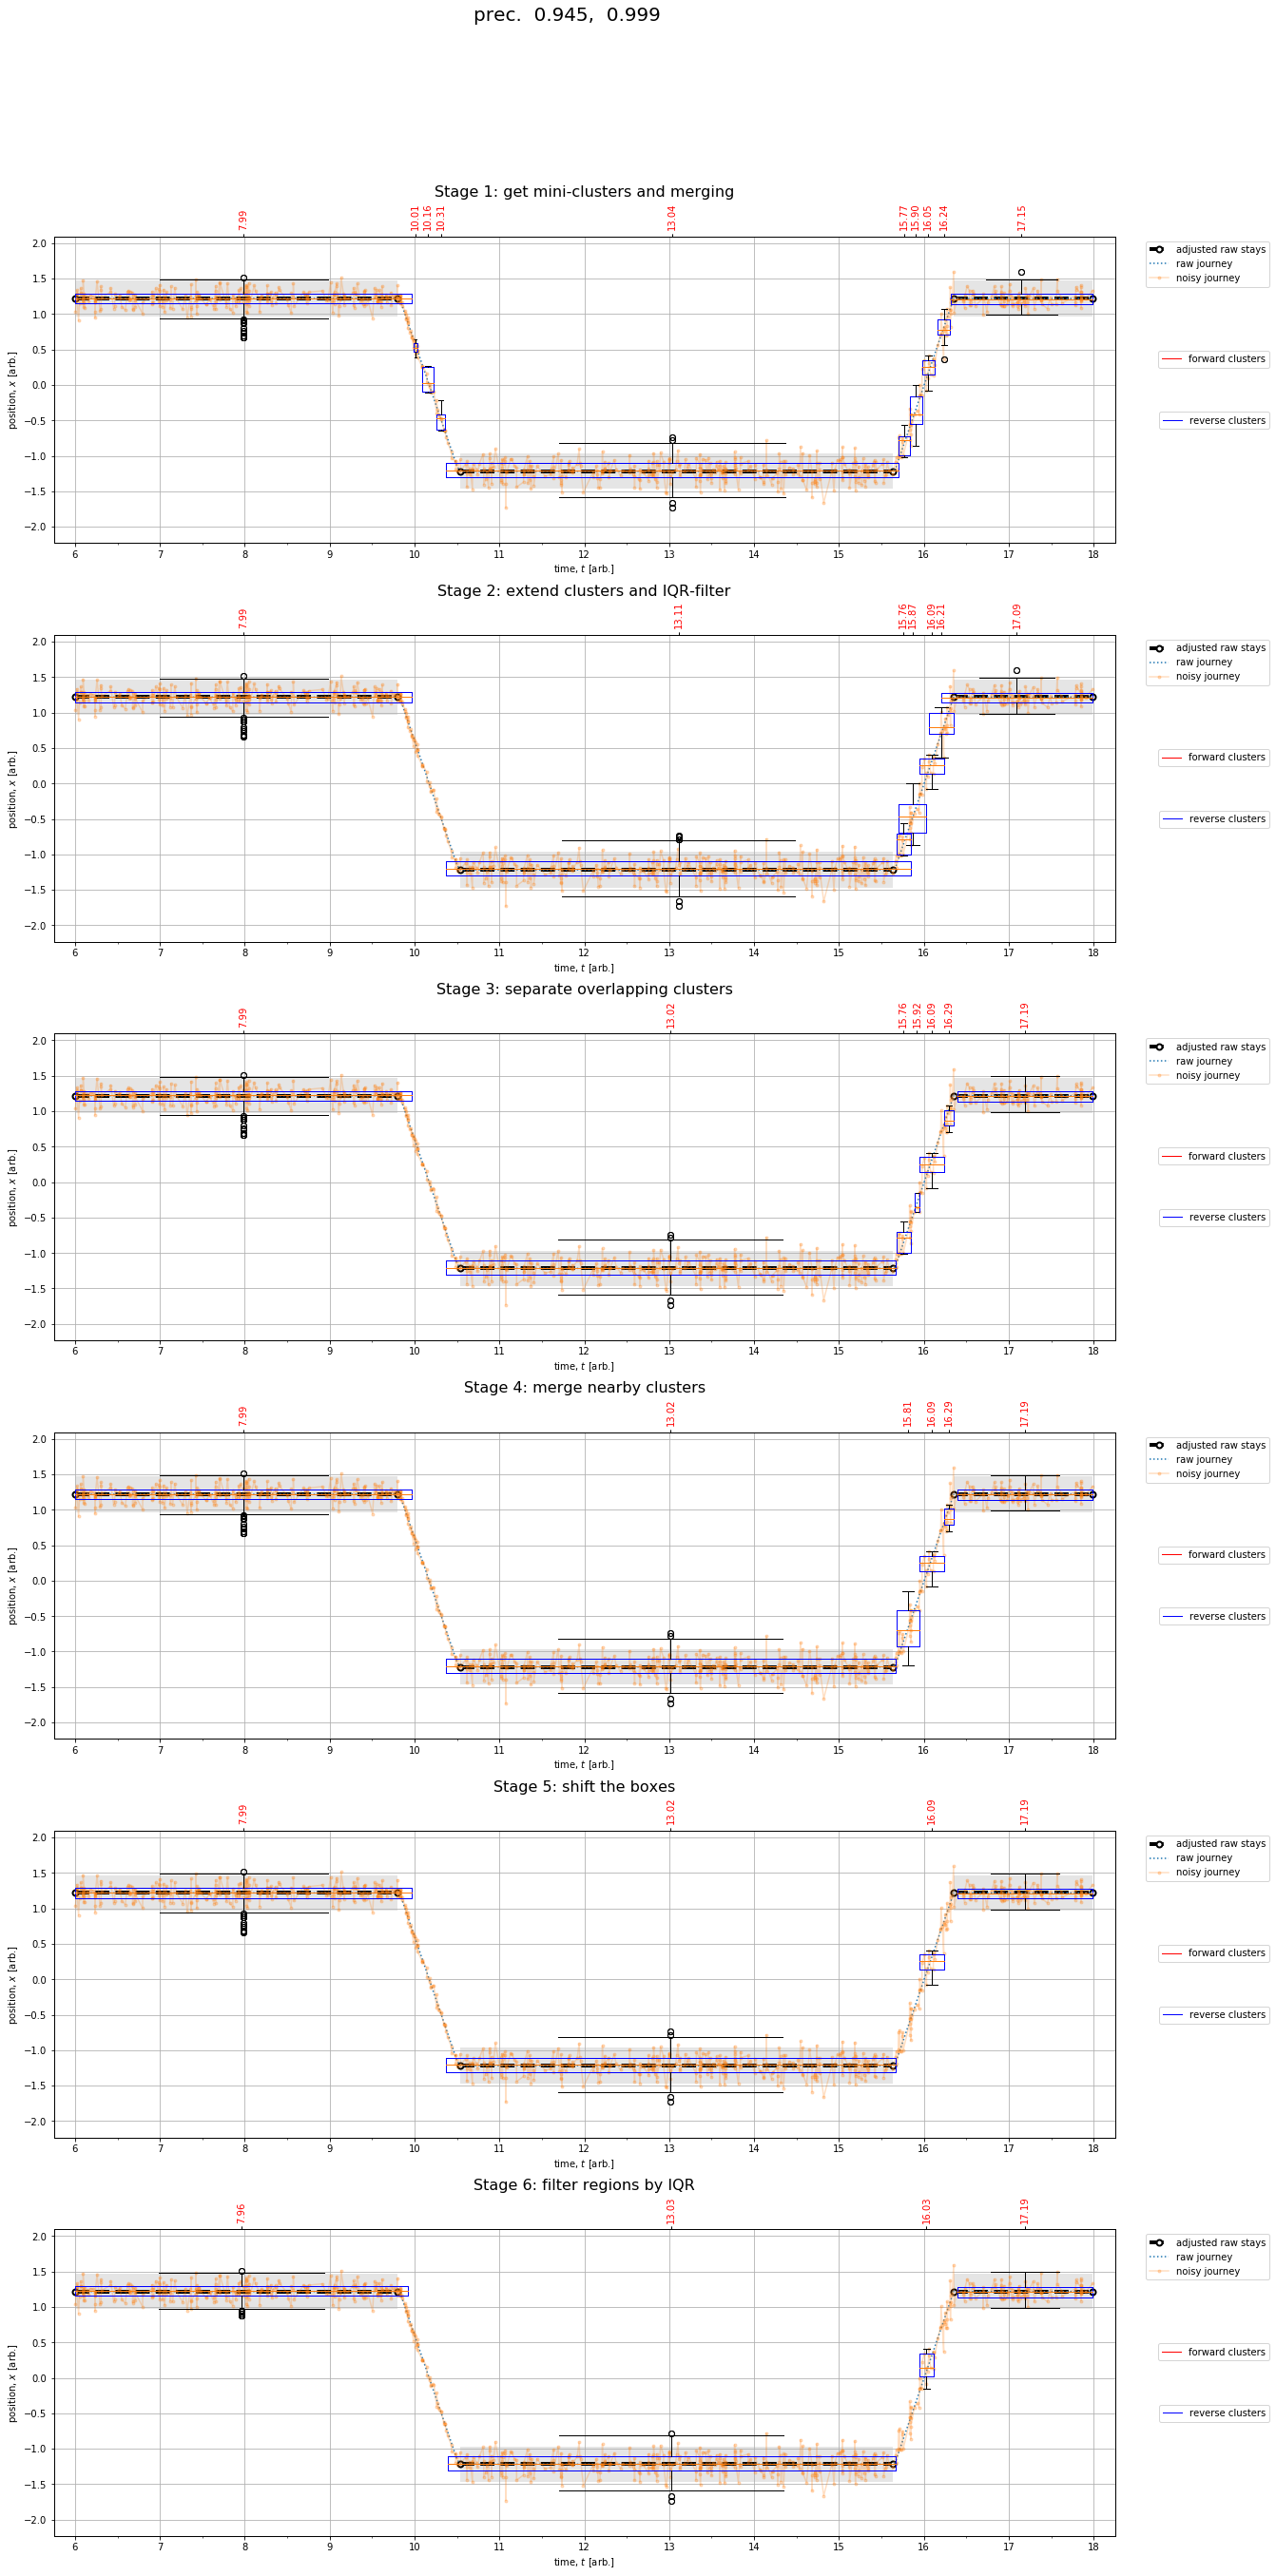

In [80]:
prec, rec, conmat = eval_synth_data(segments, t_arr, all_clusters[-1])

len_all_clusts = len(all_clusters)

fig, axs = plt.subplots(len_all_clusts,1,figsize=[20,len_all_clusts*7])
#fig.tight_layout()
'''
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots
'''
fig.subplots_adjust(bottom=0.1, top=0.9, hspace=0.3)

ylim = [x_arr.min()-2*dist_thresh, x_arr.max()+2*dist_thresh]

axs =axs.flatten()

for i in range(len_all_clusts):
    try:
        ax = axs[i]
        add_plot_cluster_boxplots(t_arr, r_arr, x_arr, t_segs, x_segs, all_clusters[i], switch_indices(all_clusters[i], t_arr.shape[0]), min_configs, ax)
        ax.set_ylim(ylim);
        ax.set_title(f"{stage_titels[i]}", fontsize=16)
    except:
        pass

fig.suptitle(f"prec. {prec:6.3f}, {rec:6.3f}", fontsize=20);

In [64]:
clust_set_nr = 5

print(f"  IQR-len,    dur,  dmedi,   dmea,   mean, median")
for n in range(len(all_clusters[clust_set_nr])):
    if n == 0:
        printstr = get_clust_metrics(all_clusters[clust_set_nr][n], t_arr, x_arr, time_thresh)
        print(f"{n:4d} {printstr}")
    else:
        printstr = get_gap_metrics(all_clusters[clust_set_nr][n-1],all_clusters[clust_set_nr][n], t_arr, x_arr, time_thresh)
        print(f"     {printstr}")
        printstr = get_clust_metrics(all_clusters[clust_set_nr][n], t_arr, x_arr, time_thresh)
        print(f"{n:4d} {printstr}")


  IQR-len,    dur,  dmedi,   dmea,   mean, median
   0  302,  3.915,   ----,   ----,  1.215,  1.223
       43,  0.469,  2.430,  2.426,  0.115,  0.249  
   1  360,  5.274,   ----,   ----, -1.211, -1.207
       29,  0.287,  1.353,  1.365, -0.661, -0.694  
   2   14,  0.161,   ----,   ----,  0.154,  0.146
       27,  0.284,  1.069,  1.065,  0.879,  0.823  
   3  105,  1.593,   ----,   ----,  1.219,  1.215


In [ ]:
from helper__3stays_v3_scripts__eval import get_segments_scores